In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,roc_curve,classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

In [3]:
data=pd.read_csv('/content/titanic_train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


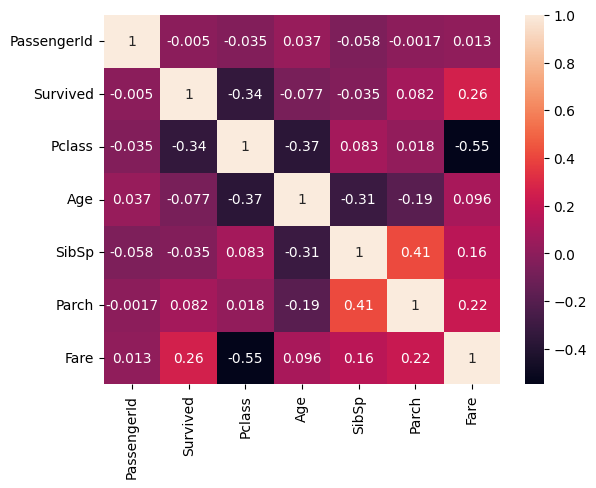

In [5]:
# Convert relevant columns to numeric, handling errors
numeric_columns = ['Age', 'SibSp', 'Parch', 'Fare']  # Add other potential numeric columns
for col in numeric_columns:
    try:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    except:
        print(f"Could not convert column {col}")

# Select only numeric columns for correlation
numeric_data = data.select_dtypes(include=np.number)

# Calculate correlations and plot heatmap
sns.heatmap(numeric_data.corr(), annot=True)
plt.show()

In [6]:
data.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


<Axes: >

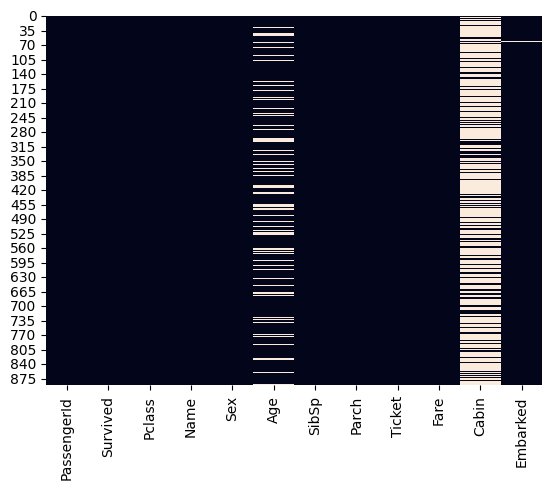

In [7]:
sns.heatmap(data.isna(),cbar=False)

<Axes: xlabel='Pclass', ylabel='Age'>

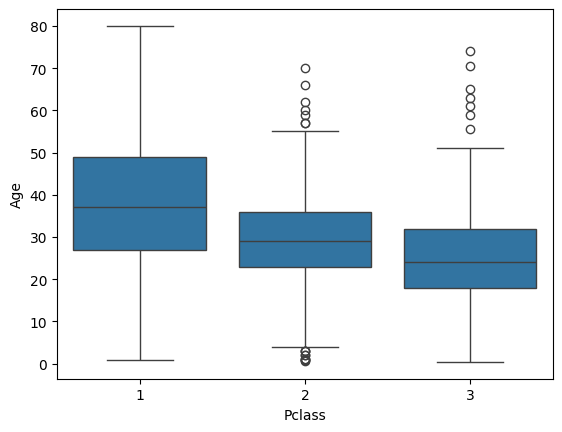

In [8]:
sns.boxplot(x='Pclass',y='Age',data=data)

In [9]:
def age_change(cols):
  age=cols[0]
  pcls=cols[1]
  if pd.isnull(age):
    if pcls==1:
      return 39
    elif pcls==2:
      return 29
    elif pcls==3:
      return 24
  else:
    return age

data['Age'].fillna(data[['Age','Pclass']].apply(age_change,axis=1),inplace=True)

In [10]:
data['Age']=data['Age'].astype(int)

In [11]:
display(data[data['Embarked'].isna()])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80.0,B28,NaN


In [12]:
new_data=data[(data['Pclass']==1) & (data['Fare']>=78) & (data['Fare']<=85)]['Embarked']
print(new_data.value_counts())

Embarked
C    11
S     8
Name: count, dtype: int64


In [13]:
data['Embarked'].fillna('C', inplace=True)

In [14]:
data['Embarked'].isna().sum()

0

In [15]:
data.nunique()

,0
PassengerId,891
Survived,2
Pclass,3
Name,891
Sex,2
Age,71
SibSp,7
Parch,7
Ticket,681
Fare,248


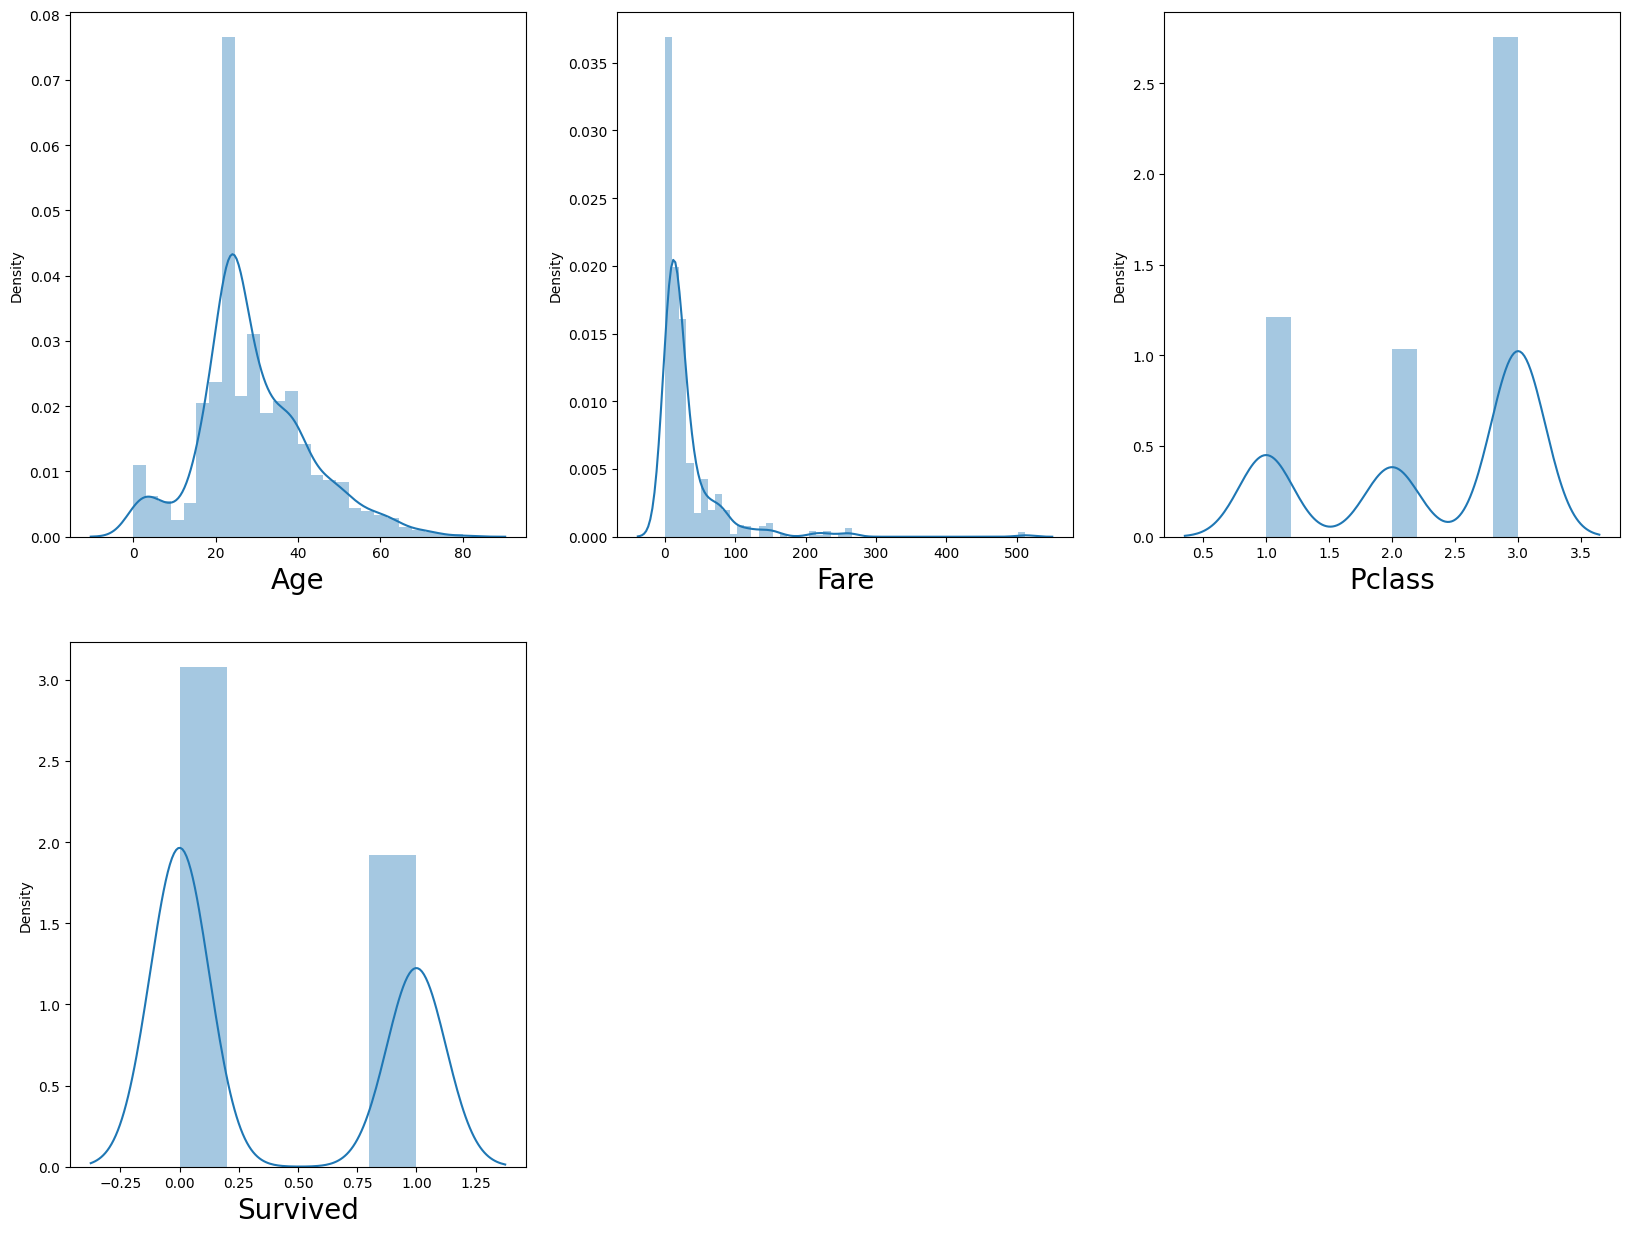

In [16]:
plt.figure(figsize=(20,15))
plotnumber=1
for column in data[['Age','Fare','Pclass','Survived']]:
    if plotnumber <=6:
        ax=plt.subplot(2,3,plotnumber)
        sns.distplot(data[column])
        plt.xlabel(column,fontsize=20)
    plotnumber +=1
plt.show()

In [17]:
z_score=zscore(data[['Age','Fare','Pclass','Survived']])
abs_z_score=np.abs(z_score)
filtering_entry=(abs_z_score < 3).all(axis=1)
df=data[filtering_entry]
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000
mean,444.748843,0.378472,2.343750,28.702546,0.520833,0.368056,26.500689
std,257.517259,0.485287,0.819028,12.781910,1.104937,0.794651,29.400192
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,221.750000,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800
50%,444.500000,0.000000,3.000000,26.000000,0.000000,0.000000,13.860400
75%,664.250000,1.000000,3.000000,36.000000,1.000000,0.000000,29.775000
max,891.000000,1.000000,3.000000,66.000000,8.000000,6.000000,164.866700


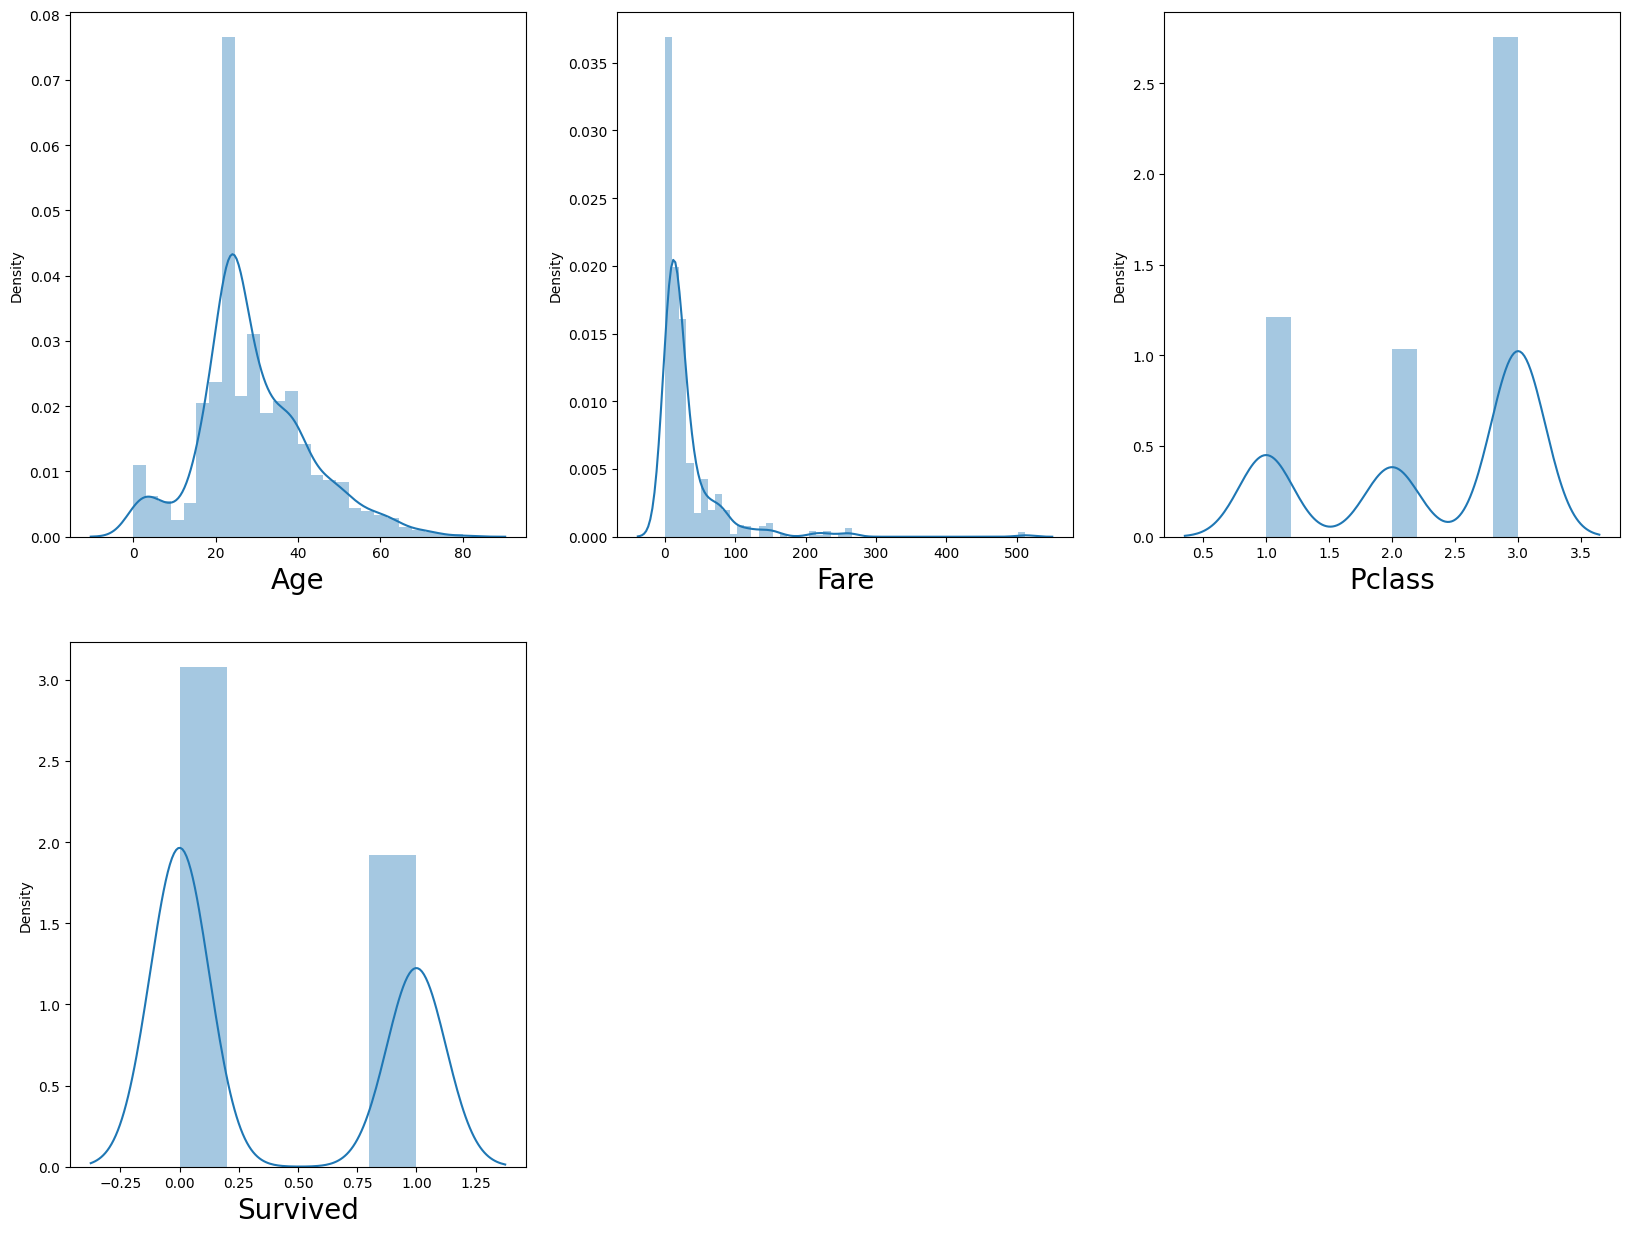

In [18]:
plt.figure(figsize=(20,15))
plotnumber=1
for column in (data[['Age','Fare','Pclass','Survived']]):
    if plotnumber<=6:
        ax=plt.subplot(2,3,plotnumber)
        sns.distplot(data[column])
        plt.xlabel(column,fontsize=20)
    plotnumber +=1
plt.show()

,count
Survived,
0,549
1,342


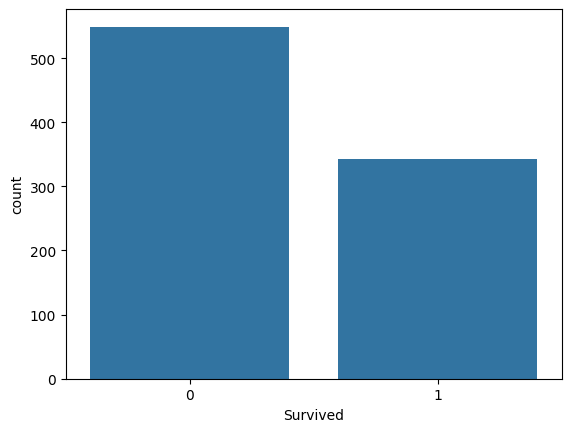

In [19]:
sns.countplot(x='Survived',data=data)
data['Survived'].value_counts()

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64

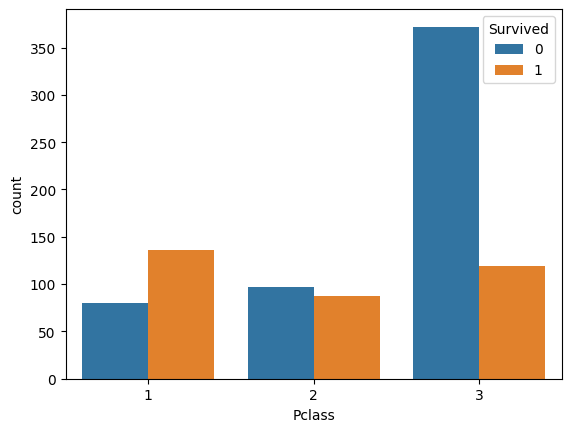

In [20]:
sns.countplot(x='Pclass',hue='Survived',data=data)
data.groupby(['Pclass','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

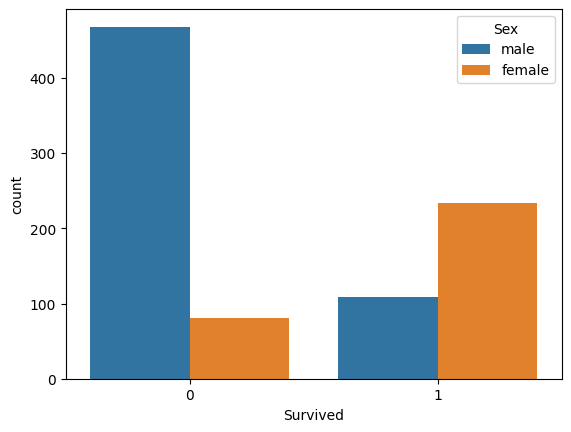

In [21]:
sns.countplot(x='Survived',hue='Sex',data=data)
data.groupby(['Sex','Survived'])['Survived'].count()

<Axes: xlabel='Pclass', ylabel='count'>

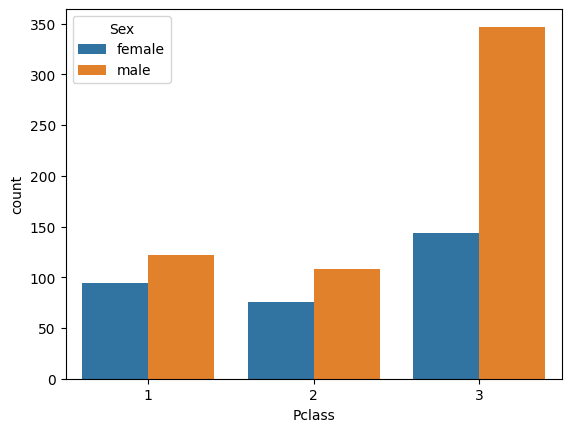

In [22]:
sns.countplot(x='Pclass',hue='Sex',data=data)

Embarked  Survived
C         0            75
          1            95
Q         0            47
          1            30
S         0           427
          1           217
Name: Survived, dtype: int64

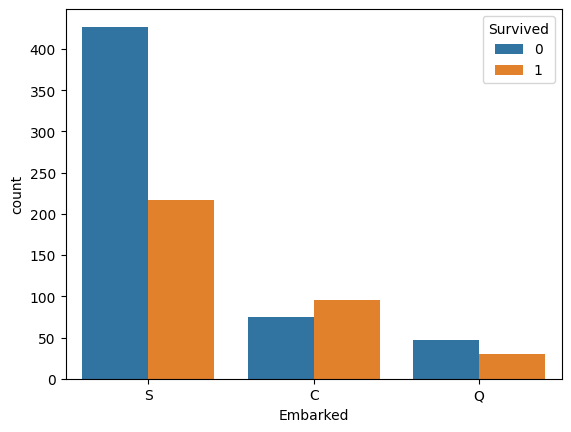

In [23]:
sns.countplot(x='Embarked',hue='Survived',data=data)
data.groupby(['Embarked','Survived'])['Survived'].count()

Parch  Survived
0      0           445
       1           233
1      0            53
       1            65
2      0            40
       1            40
3      0             2
       1             3
4      0             4
5      0             4
       1             1
6      0             1
Name: Survived, dtype: int64

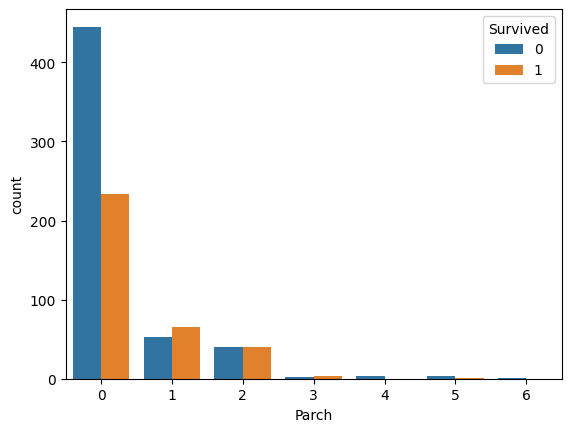

In [24]:
sns.countplot(data, x='Parch', hue='Survived')
data.groupby(['Parch','Survived'])['Survived'].count()

In [25]:
sex = pd.get_dummies(data['Sex'], drop_first=True)
embarked = pd.get_dummies(data['Embarked'], drop_first=True)

In [26]:
data.drop(['Name','Ticket','Sex','Embarked'],inplace=True,axis=1)

In [27]:
data=pd.concat([data,sex,embarked],axis=1)
data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,male,Q,S
0,1,0,3,22,1,0,7.2500,NaN,True,False,True
1,2,1,1,38,1,0,71.2833,C85,False,False,False
2,3,1,3,26,0,0,7.9250,NaN,False,False,True
3,4,1,1,35,1,0,53.1000,C123,False,False,True
4,5,0,3,35,0,0,8.0500,NaN,True,False,True


In [28]:
X=data.drop(['Survived','Cabin'],axis=1)
y=data['Survived']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [30]:
performance = {}

In [31]:
model1 = LogisticRegression()
model1.fit(X_train, y_train)

LogisticRegression()

In [59]:
model1_pred=model1.predict(X_test)
performance['Logistic Regression'] = accuracy_score(y_test, model1_pred)
cross1 = cross_val_score(model1, X_train, y_train, cv=5)
print("Cross Validation Score:",cross1.mean() * 100)

Cross Validation Score: 78.85500174276751


In [33]:
confusion_matrix(y_test, model1_pred)

array([[78,  4],
       [23, 29]])

In [54]:
print("Classification Report for Logistic Regression Model\n")
print(classification_report(y_test, model1_pred))

Classification Report for Logistic Regression Model

              precision    recall  f1-score   support

           0       0.60      0.72      0.66        85
           1       0.27      0.18      0.22        49

    accuracy                           0.52       134
   macro avg       0.44      0.45      0.44       134
weighted avg       0.48      0.52      0.50       134



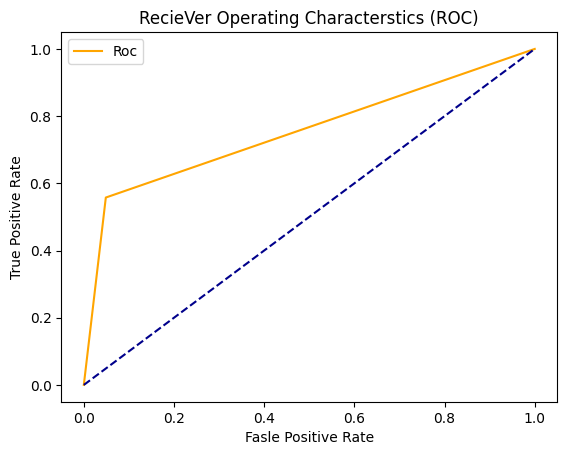

In [35]:
fpr,tpr,threshold =roc_curve(y_test,model1_pred)
plt.plot(fpr,tpr,color='orange',label='Roc')
plt.plot([0,1],[0,1],color='darkblue',linestyle='--')
plt.xlabel('Fasle Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RecieVer Operating Characterstics (ROC)')
plt.legend()
plt.show()

In [60]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15)
def metrics_score(cnn,x_train,x_test,y_train,y_test,train=True):
    if train:
        y_pred=cnn.predict(X_train)
        print(accuracy_score(y_train,y_pred)*100)
    elif train==False:
        pred=cnn.predict(X_test)
        print(accuracy_score(y_test,pred)*100)
        print(classification_report(y_test,pred))

In [38]:
model2=RandomForestClassifier()
model2.fit(X_train, y_train)

RandomForestClassifier()

In [62]:
model2_pred=model2.predict(X_test)
performance['Random Forest Classifier'] = accuracy_score(y_test, model2_pred)
cross2=cross_val_score(model2, X_train, y_train, cv=5)
print("Cross Validation Score:",cross2.mean() * 100)

Cross Validation Score: 83.35482746601602


In [40]:
confusion_matrix(y_test, model2_pred)

array([[77,  8],
       [16, 33]])

In [52]:
print("Classification Report for Random Forest Model\n")
print(classification_report(y_test, model2_pred))

Classification Report for Random Forest Model

              precision    recall  f1-score   support

           0       0.83      0.91      0.87        85
           1       0.80      0.67      0.73        49

    accuracy                           0.82       134
   macro avg       0.82      0.79      0.80       134
weighted avg       0.82      0.82      0.82       134



In [42]:
model3=DecisionTreeClassifier()
model3.fit(X_train,y_train)

DecisionTreeClassifier()

In [63]:
model3_pred=model3.predict(X_test)
performance['Decision Tree Classifier']=accuracy_score(y_test,model3_pred)
cross3=cross_val_score(model3,X_train,y_train,cv=5)
print("Cross Validation Score:",cross3.mean()*100)

Cross Validation Score: 76.21645172533984


In [66]:
print("Classification Report for Decision Tree Model\n")
print(classification_report(y_test, model2_pred))

Classification Report for Decision Tree Model

              precision    recall  f1-score   support

           0       0.95      0.99      0.97        75
           1       0.98      0.93      0.96        59

    accuracy                           0.96       134
   macro avg       0.97      0.96      0.96       134
weighted avg       0.96      0.96      0.96       134



In [64]:
performance

{'Logistic Regression': 0.8059701492537313,
 'Random Forest Classifier': 0.9626865671641791,
 'Decision Tree Classifier': 0.9328358208955224}

<Axes: >

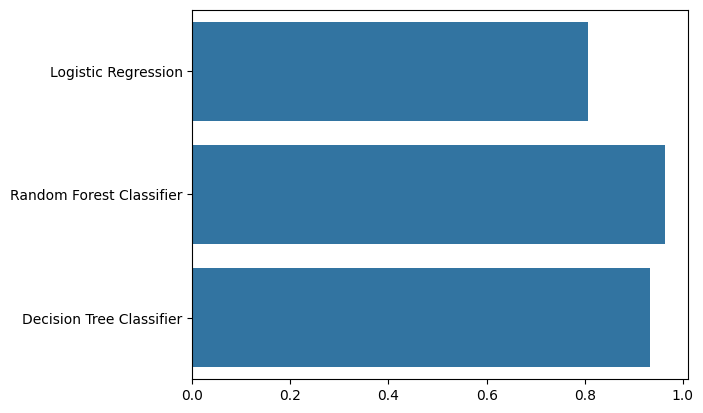

In [74]:
sns.barplot(y=performance.keys(), x=performance.values())

In [46]:
output = pd.DataFrame({'PassengerId': X_test.index +1, 'Survived': model2_pred})
output.to_csv('Result.csv', index=False)

In [47]:
res=pd.read_csv('/content/Result.csv')
res.head()

,PassengerId,Survived
0,736,0
1,254,0
2,387,0
3,130,0
4,888,1
